In [150]:
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import csv
from sklearn import linear_model
import numpy as np
import statsmodels.api as sm
from scipy import stats



In [151]:
url = "https://www.tomato.gg/tank-stats/NA"

response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

script = soup.find("script", {"id": "__NEXT_DATA__"})

if script:
    contents = script.contents[0]
    data = json.loads(contents)
    initial_data = data["props"]["pageProps"]["data"]
    
    fieldnames = set()
    for obj in initial_data:
        fieldnames.update(obj.keys())

    # Specify the filename for the CSV
    filename = "output.csv"

    # Write JSON objects to CSV with UTF-8 encoding
    with open(filename, mode="w", newline="", encoding="utf-8") as file:  # Specify UTF-8 encoding
        writer = csv.DictWriter(file, fieldnames=list(fieldnames))
        writer.writeheader()
        writer.writerows(initial_data)   
else:
    print("Error data not found")


In [152]:
url = "https://www.tomato.gg/economics/all"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

script = soup.find("script", {"id": "__NEXT_DATA__"})
if script:
    contents = script.contents[0]
    data = json.loads(contents)
    initial_data = data["props"]["pageProps"]["data"]['data']

    fieldnames = set()
    for obj in initial_data:
        fieldnames.update(obj.keys())
        
    filename = "output.csv"

    with open(filename, mode="w", newline="", encoding="utf-8") as file:  # Specify UTF-8 encoding
        writer = csv.DictWriter(file, fieldnames=list(fieldnames))
        writer.writeheader()
        writer.writerows(initial_data)  
    
else:
    print("Error data not found")

In [153]:
data = pd.DataFrame()
generalDf = pd.read_csv('rawDataOutput/generalData.csv', encoding='utf')
economicDF = pd.read_csv('rawDataOutput/econData.csv', encoding='utf')

combinded = pd.merge(generalDf, economicDF, how='inner', on='tank_id')


data['Id'] = combinded['tank_id']
data['Name'] = combinded['name_x']
data['isPrem'] = combinded['isPrem_x']
data['tier'] = combinded['tier_x']
data['class'] = combinded['class_x']

data['battles'] = combinded['battles_x']
data['winrate'] = combinded['winrate']
data['survival'] = combinded['survival']
data['damage'] = combinded['damage']
data['shotCost'] = combinded['cost_per_shot']
data['repairCost'] = combinded['avg_repair_cost']
data['avg_ammo_cost'] = combinded['avg_ammo_cost']
data['avg_profit'] = combinded['avg_profit']

data

,Id,Name,isPrem,tier,class,battles,winrate,survival,damage,shotCost,repairCost,avg_ammo_cost,avg_profit
0,60225,Bourrasque,True,8,MT,110271,53.36,27.44,1391,2964,6487,25611,39905
1,50193,Skorpion G,True,8,TD,82120,48.96,30.85,1264,2181,5966,16516,42594
2,61505,ELC EVEN 90,True,8,LT,80964,50.58,23.45,593,1884,4724,10772,37536
3,45057,SU-130PM,True,8,TD,77995,49.72,34.90,1386,2103,5616,16120,45312
4,60481,Char Futur 4,True,9,MT,72969,50.34,28.56,1539,1849,15519,16691,7028
...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,61457,Pz. III K,True,5,MT,204,50.14,26.47,421,1460,1881,22337,-1586
550,4417,G1 R,False,5,MT,202,49.34,26.24,482,2466,2094,28543,-7349
551,63761,Pz. 58,True,8,MT,148,46.85,25.00,868,2510,7002,25215,26060
552,52257,M4A2E4,True,5,MT,89,53.07,19.10,488,2226,1592,56026,-13157


The differencees between standard and premium tanks: winrate, profits

Lets start by simply graphing the average amoung of damage between premium and standard tanks

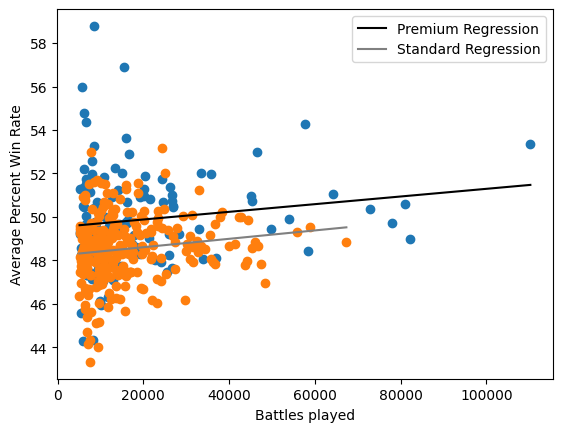

In [154]:
premiumGeneral = data[data['isPrem'] == True ]
stdGeneral = data[data['isPrem'] == False]


premiumGeneral = premiumGeneral[premiumGeneral['battles'] > 5000]
stdGeneral = stdGeneral[stdGeneral['battles'] > 5000]

reg = linear_model.LinearRegression()

x = np.array(premiumGeneral['battles']).reshape(-1,1)
y = premiumGeneral['winrate']

reg.fit(x,y)

predictions = reg.predict(x)
plt.scatter(x,y)
plt.plot(x, predictions, color='black', label='Premium Regression')

x = np.array(stdGeneral['battles']).reshape(-1,1)
y = stdGeneral['winrate']

reg.fit(x,y)

predictions = reg.predict(x)
plt.scatter(x,y)
plt.plot(x, predictions, color='gray', label='Standard Regression')

plt.xlabel('Battles played')
plt.ylabel('Average Percent Win Rate')
plt.legend()

plt.show()

This plot certainly seems to imply a magintued of difference between damage as we know however correlation is not nessary causesation. We can apply a hypotheis test to confirm a true between Premium and higher winrate

Null Hypothesis: Winrate is not affected by whether a tank is Premium or Standard
Alternative: Winrate of Premium tanks is likely to be higher than that of a standard one.
We will test this assumtion with a 0.05 confidence level

In [155]:
gold_winrates = premiumGeneral['winrate']
standard_winrates = stdGeneral['winrate']

t_stat, p_val = stats.ttest_ind(gold_winrates, standard_winrates)

print("t-statistic: {:.2f}".format(t_stat))
print("p-value: {:.4f}".format(p_val))

if(p_val < 0.05):
    print('Reject Null Hypothesis')
else:
    print('Null Hypotheis remains true')

t-statistic: 6.62
p-value: 0.0000
Reject Null Hypothesis


The resulting small p-value gives us enought evidence to reject the null hypotheis and conclude a being a premium does correlate to a higher winrate

Now lets test profits of premium tanks

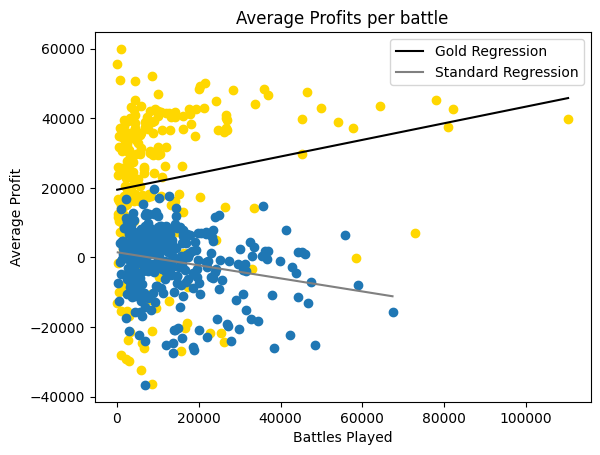

In [156]:
premiumEcon = data[data['isPrem'] == True]
stdEcon = data[data['isPrem'] == False]

reg = linear_model.LinearRegression()

x = np.array(premiumEcon['battles']).reshape(-1,1)
y = premiumEcon['avg_profit']

reg.fit(x,y)

predictions = reg.predict(x)
plt.scatter(x,y,color = 'gold')
plt.plot(x, predictions, color='black', label='Gold Regression')

x = np.array(stdEcon['battles']).reshape(-1,1)
y = stdEcon['avg_profit']

reg.fit(x,y)
predictions = reg.predict(x)
plt.scatter(x,y)
plt.plot(x, predictions, color='gray', label='Standard Regression')

plt.ylabel('Average Profit')
plt.xlabel('Battles Played')
plt.title('Average Profits per battle')
plt.legend()
plt.show()

Another Hypothesis test

In [157]:
gold_profits = premiumEcon['avg_profit']
standard_profit = stdEcon['avg_profit']

t_stat, p_val = stats.ttest_ind(gold_winrates, standard_winrates, equal_var=False)

print("t-statistic: {:.2f}".format(t_stat))
print("p-value: {:.4f}".format(p_val/2))

t-statistic: 5.88
p-value: 0.0000


Again we reject null hypothesis

It may seem strange how are non paying players actually playing the game. As it turns out this is due to the fact that lower tier tanks are more profitable, war gaming wants to encorage people to play lower tier

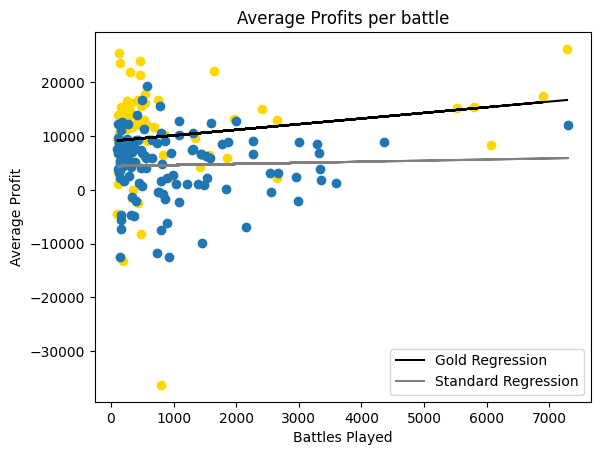

In [158]:
premiumEcon = economicDF[economicDF['isPrem'] == True]
stdEcon = economicDF[economicDF['isPrem'] == False]

stdEcon = stdEcon[stdEcon['tier'] < 6]
premiumEcon = premiumEcon[premiumEcon['tier'] < 6]

reg = linear_model.LinearRegression()

x = np.array(premiumEcon['battles']).reshape(-1,1)
y = premiumEcon['avg_profit']

reg.fit(x,y)

predictions = reg.predict(x)
plt.scatter(x,y,color = 'gold')
plt.plot(x, predictions, color='black', label='Gold Regression')

x = np.array(stdEcon['battles']).reshape(-1,1)
y = stdEcon['avg_profit']

reg.fit(x,y)
predictions = reg.predict(x)
plt.scatter(x,y)
plt.plot(x, predictions, color='gray', label='Standard Regression')

plt.ylabel('Average Profit')
plt.xlabel('Battles Played')
plt.title('Average Profits per battle')
plt.legend()
plt.show()

There are many things that can affect profits.

In [159]:
data['binaryPrem'] = data['isPrem'].apply(lambda x : 1 if x else 0)
types = {'SPG' : 0, 'LT' : 1, 'MT' : 2, 'HT' : 3, 'TD' : 4}
data['numClass'] = data['class'].apply(lambda x : types[x])
data

,Id,Name,isPrem,tier,class,battles,winrate,survival,damage,shotCost,repairCost,avg_ammo_cost,avg_profit,binaryPrem,numClass
0,60225,Bourrasque,True,8,MT,110271,53.36,27.44,1391,2964,6487,25611,39905,1,2
1,50193,Skorpion G,True,8,TD,82120,48.96,30.85,1264,2181,5966,16516,42594,1,4
2,61505,ELC EVEN 90,True,8,LT,80964,50.58,23.45,593,1884,4724,10772,37536,1,1
3,45057,SU-130PM,True,8,TD,77995,49.72,34.90,1386,2103,5616,16120,45312,1,4
4,60481,Char Futur 4,True,9,MT,72969,50.34,28.56,1539,1849,15519,16691,7028,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,61457,Pz. III K,True,5,MT,204,50.14,26.47,421,1460,1881,22337,-1586,1,2
550,4417,G1 R,False,5,MT,202,49.34,26.24,482,2466,2094,28543,-7349,0,2
551,63761,Pz. 58,True,8,MT,148,46.85,25.00,868,2510,7002,25215,26060,1,2
552,52257,M4A2E4,True,5,MT,89,53.07,19.10,488,2226,1592,56026,-13157,1,2


In [160]:
X = data[['binaryPrem', 'tier', 'numClass', 'winrate', 'survival', 'damage', 'shotCost', 'repairCost', 'avg_ammo_cost']]
y = data['avg_profit']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

pVals = model.pvalues

pVals.sort_values(ascending=False)
pVals = pVals[pVals < 0.05]
pVals

binaryPrem       3.192507e-54
tier             1.023408e-23
survival         5.470422e-05
damage           7.135638e-06
repairCost       4.093901e-52
avg_ammo_cost    2.834333e-14
dtype: float64

In [161]:
std_coeffs = model.params / y.std()
abs_coeffs = abs(std_coeffs)
sorted_coeffs = abs_coeffs.sort_values()
sorted_coeffs

avg_ammo_cost    0.000033
shotCost         0.000066
repairCost       0.000165
damage           0.000651
winrate          0.001887
survival         0.017016
numClass         0.037631
tier             0.411974
binaryPrem       0.911315
const            0.931433
dtype: float64

Looking at the p values we can conclude being premium, teir, survival, damage, repairCost, and avg_ammo_cost effect profits. We can also see that being a premium is the largest influence on profits. Of them we can also see that being a premium has the largest effect 

We can make a machine learning function that predicts average profit after a battle given this data we will use gradiant decent
 

In [162]:
trainingData = pd.DataFrame()

trainingData['binaryPrem'] = data['binaryPrem']
trainingData['tier'] = data['tier']
trainingData['class'] = data['numClass']
trainingData['survival'] = data['survival']
trainingData['damage'] = data['damage']
trainingData['repairCost'] = data['repairCost']
trainingData['avg_ammo_cost'] = data['avg_ammo_cost']
trainingData['avg_profit'] = data['avg_profit']
trainingData



,binaryPrem,tier,class,survival,damage,repairCost,avg_ammo_cost,avg_profit
0,1,8,2,27.44,1391,6487,25611,39905
1,1,8,4,30.85,1264,5966,16516,42594
2,1,8,1,23.45,593,4724,10772,37536
3,1,8,4,34.90,1386,5616,16120,45312
4,1,9,2,28.56,1539,15519,16691,7028
...,...,...,...,...,...,...,...,...
549,1,5,2,26.47,421,1881,22337,-1586
550,0,5,2,26.24,482,2094,28543,-7349
551,1,8,2,25.00,868,7002,25215,26060
552,1,5,2,19.10,488,1592,56026,-13157


In [163]:
def gradientDescent(X, y, theta, alpha, iterations):
    m = len(y)
    for i in range(iterations):
        h = np.dot(X, theta)
        theta -= alpha * (1/m) * np.dot(X.T, (h-y))
    return theta

In [164]:
y = trainingData["avg_profit"]
X = trainingData.drop("avg_profit", axis=1)

In [165]:
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X = np.hstack((np.ones((X.shape[0], 1)), X))

alpha = 0.01
num_iterations = 1000
theta = np.zeros(X.shape[1])

In [166]:
theta = gradientDescent(X, y, theta, alpha, num_iterations)
print("Learned Parameters (Theta):", theta)

Learned Parameters (Theta): [  8616.18035926  10524.55445261   6960.68304709    948.51230973
   -628.38737982   2615.76384321 -11971.79872323  -7674.70932628]


In [167]:
def predictProfit(isPrem, tier, classVal, survival, damage, repairCost, ammoCost):
    profit = 0
    
    premNorm = (isPrem - np.mean(trainingData["binaryPrem"])) / np.std(trainingData["binaryPrem"])
    tierNorm = (tier - np.mean(trainingData["tier"])) / np.std(trainingData["tier"])
    classNorm = (classVal - np.mean(trainingData['class'])) / np.std(trainingData["class"])
    survivalNorm = (survival - np.mean(trainingData['survival'])) / np.std(trainingData['survival'])
    damageNorm = (damage - np.mean(trainingData['damage'])) / np.std(trainingData['damage'])
    repairNorm = (repairCost - np.mean(trainingData['repairCost'])) / np.std(trainingData['repairCost'])
    ammoNorm = (ammoCost - np.mean(trainingData['avg_ammo_cost'])) / np.std(trainingData['avg_ammo_cost'])

    features = np.array([1, premNorm, tierNorm, classNorm, survivalNorm, damageNorm, repairNorm, ammoNorm])
    profit = np.dot(features, theta)
    
    return profit
    

In [168]:
prem = {True : 1, False : 0}
types = {'LT' : 0, 'MT' : 1, 'HT' : 2, 'TD' : 3, 'SPG' : 4}


prem = prem[False]
tier = 7
classval = types['HT']
survival = 25.86
damage = 894
repairCost = 8700
ammoCost = 20000

profit = predictProfit(prem,tier,classval,survival,damage,repairCost,ammoCost)
print("Predicted profit:", profit)


Predicted profit: -2451.879406729571


In [169]:
data

,Id,Name,isPrem,tier,class,battles,winrate,survival,damage,shotCost,repairCost,avg_ammo_cost,avg_profit,binaryPrem,numClass
0,60225,Bourrasque,True,8,MT,110271,53.36,27.44,1391,2964,6487,25611,39905,1,2
1,50193,Skorpion G,True,8,TD,82120,48.96,30.85,1264,2181,5966,16516,42594,1,4
2,61505,ELC EVEN 90,True,8,LT,80964,50.58,23.45,593,1884,4724,10772,37536,1,1
3,45057,SU-130PM,True,8,TD,77995,49.72,34.90,1386,2103,5616,16120,45312,1,4
4,60481,Char Futur 4,True,9,MT,72969,50.34,28.56,1539,1849,15519,16691,7028,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,61457,Pz. III K,True,5,MT,204,50.14,26.47,421,1460,1881,22337,-1586,1,2
550,4417,G1 R,False,5,MT,202,49.34,26.24,482,2466,2094,28543,-7349,0,2
551,63761,Pz. 58,True,8,MT,148,46.85,25.00,868,2510,7002,25215,26060,1,2
552,52257,M4A2E4,True,5,MT,89,53.07,19.10,488,2226,1592,56026,-13157,1,2


In [170]:
predictions = trainingData.apply(
    lambda row: 
        predictProfit(row['binaryPrem'], row['tier'], row['class'], row['survival'], row['damage'], row['repairCost'], row['avg_ammo_cost']), axis=1)

errors = np.abs(predictions - trainingData['avg_profit'])

avg_error = np.mean(errors)
print("Average error:", avg_error)

Average error: 7006.294365931106
